#### Forecast Demand whit ARIMA Model

In [1]:
# Importing Basic libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing time series specific libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import levene
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
import pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace import sarimax
import prophet
from prophet import Prophet# Importing Basic libraries 


# Miscellaneous libararies
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from random import random

# Libaraies for evaluation of model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMAResults

# Importing time series specific libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import bartlett
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
import pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace import sarimax
import prophet
from prophet import Prophet
from scipy.stats import levene
# Miscellaneous libararies
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from random import random

# Libaraies for evaluation of model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMAResults


c:\Users\milla\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
 #?  Function for solver data import
def import_data(x):
    """Import the data from a file into the Excel document"""
    global df 
    route_script = os.getcwd()
# Excel name :
    name_doc = x
#Combine script route and name_doc
    route_doc=os.path.join(route_script,name_doc)
#Load data in a Data Frame to panda 
    df=pd.read_excel(route_doc)
    return df

In [3]:
 #?Call the function for data analysis 
import_data("load_IJV.xlsx")

,idprov,fecha,dem1,dem2,dem3,dem4,dem5,dem6,dem7,dem8,...,dem16,dem17,dem18,dem19,dem20,dem21,dem22,dem23,dem24,dem25
0,IJV,2007-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IJV,2007-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IJV,2007-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IJV,2007-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IJV,2007-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,IJV,2018-04-14,15.0,14.0,13.0,13.0,13.0,13.0,13.0,12.0,...,12.0,12.0,13.0,14.0,15.0,16.0,16.0,16.0,15.0,16.0
3916,IJV,2018-04-15,15.0,14.0,14.0,13.0,13.0,13.0,12.0,12.0,...,12.0,12.0,13.0,14.0,15.0,15.0,16.0,16.0,15.0,16.0
3917,IJV,2018-04-16,14.0,13.0,13.0,13.0,12.0,13.0,12.0,12.0,...,12.0,12.0,12.0,12.0,14.0,14.0,14.0,13.0,12.0,14.0
3918,IJV,2018-04-17,11.0,11.0,10.0,10.0,10.0,10.0,10.0,10.0,...,11.0,11.0,12.0,13.0,14.0,14.0,14.0,13.0,12.0,14.0


In [4]:
 #? shaping the data, only the last 10 years (2008 - 2017)
df = df[df["fecha"] >= '2008-01-01']
df = df[df["fecha"] <= '2017-12-31']
print(df.head())

    idprov      fecha  dem1  dem2  dem3  dem4  dem5  dem6  dem7  dem8  ...  \
159    IJV 2008-01-01   9.0   9.0   8.0   8.0   8.0   9.0   9.0  10.0  ...   
160    IJV 2008-01-02   8.0   6.0   8.0   7.0   8.0   8.0   8.0  10.0  ...   
161    IJV 2008-01-03   6.0   4.0   5.0   6.0   6.0   5.0  10.0  10.0  ...   
162    IJV 2008-01-04   6.0   6.0   7.0   6.0   6.0   8.0  10.0  11.0  ...   
163    IJV 2008-01-05   6.0   6.0   6.0   6.0   6.0   8.0   9.0  10.0  ...   

     dem16  dem17  dem18  dem19  dem20  dem21  dem22  dem23  dem24  dem25  
159   11.0   12.0   14.0   15.0   12.0   11.0   11.0   10.0   10.0   16.0  
160   12.0   15.0   17.0   16.0   11.0    9.0    8.0    7.0    6.0   17.0  
161   11.0   15.0   18.0   17.0   12.0   10.0    9.0    7.0    7.0   19.0  
162   12.0   14.0   18.0   19.0   13.0   10.0    9.0    7.0    7.0   19.0  
163   12.0   11.0   18.0   19.0   14.0   11.0   10.0    8.0    8.0   20.0  

[5 rows x 27 columns]


In [5]:
 #? removing last column
infoToUse = df.drop(columns="dem25")
infoToUse = infoToUse.drop(columns="idprov")
print(infoToUse.head())

         fecha  dem1  dem2  dem3  dem4  dem5  dem6  dem7  dem8  dem9  ...  \
159 2008-01-01   9.0   9.0   8.0   8.0   8.0   9.0   9.0  10.0  11.0  ...   
160 2008-01-02   8.0   6.0   8.0   7.0   8.0   8.0   8.0  10.0  11.0  ...   
161 2008-01-03   6.0   4.0   5.0   6.0   6.0   5.0  10.0  10.0  10.0  ...   
162 2008-01-04   6.0   6.0   7.0   6.0   6.0   8.0  10.0  11.0  11.0  ...   
163 2008-01-05   6.0   6.0   6.0   6.0   6.0   8.0   9.0  10.0  12.0  ...   

     dem15  dem16  dem17  dem18  dem19  dem20  dem21  dem22  dem23  dem24  
159   11.0   11.0   12.0   14.0   15.0   12.0   11.0   11.0   10.0   10.0  
160    8.0   12.0   15.0   17.0   16.0   11.0    9.0    8.0    7.0    6.0  
161   11.0   11.0   15.0   18.0   17.0   12.0   10.0    9.0    7.0    7.0  
162   11.0   12.0   14.0   18.0   19.0   13.0   10.0    9.0    7.0    7.0  
163   11.0   12.0   11.0   18.0   19.0   14.0   11.0   10.0    8.0    8.0  

[5 rows x 25 columns]


In [6]:
 #? restarting the index
infoToUse.index = np.arange(1, len(infoToUse) + 1, 1)
print(infoToUse.head())

       fecha  dem1  dem2  dem3  dem4  dem5  dem6  dem7  dem8  dem9  ...  \
1 2008-01-01   9.0   9.0   8.0   8.0   8.0   9.0   9.0  10.0  11.0  ...   
2 2008-01-02   8.0   6.0   8.0   7.0   8.0   8.0   8.0  10.0  11.0  ...   
3 2008-01-03   6.0   4.0   5.0   6.0   6.0   5.0  10.0  10.0  10.0  ...   
4 2008-01-04   6.0   6.0   7.0   6.0   6.0   8.0  10.0  11.0  11.0  ...   
5 2008-01-05   6.0   6.0   6.0   6.0   6.0   8.0   9.0  10.0  12.0  ...   

   dem15  dem16  dem17  dem18  dem19  dem20  dem21  dem22  dem23  dem24  
1   11.0   11.0   12.0   14.0   15.0   12.0   11.0   11.0   10.0   10.0  
2    8.0   12.0   15.0   17.0   16.0   11.0    9.0    8.0    7.0    6.0  
3   11.0   11.0   15.0   18.0   17.0   12.0   10.0    9.0    7.0    7.0  
4   11.0   12.0   14.0   18.0   19.0   13.0   10.0    9.0    7.0    7.0  
5   11.0   12.0   11.0   18.0   19.0   14.0   11.0   10.0    8.0    8.0  

[5 rows x 25 columns]


In [7]:
 #? removing February 29
print("lengthBefore =", len(infoToUse)) # checking
idx_1 = infoToUse[infoToUse["fecha"] == '2008-02-29']
idx_2 = infoToUse[infoToUse["fecha"] == '2012-02-29']
idx_3 = infoToUse[infoToUse["fecha"] == '2016-02-29']
toRemove = [idx_1.index.item(), idx_2.index.item(), idx_3.index.item()]
print(toRemove)
infoToUse = infoToUse.drop(toRemove)
print("lengthAfter =", len(infoToUse)) # checking

lengthBefore = 3653
[60, 1521, 2982]
lengthAfter = 3650


In [8]:
 #? filtering data needed
infoToUseFiltered = infoToUse[infoToUse['fecha'].dt.strftime('%m-%d') == '01-01']
print(infoToUseFiltered)

          fecha  dem1  dem2  dem3  dem4  dem5  dem6  dem7  dem8  dem9  ...  \
1    2008-01-01   9.0   9.0   8.0   8.0   8.0   9.0   9.0  10.0  11.0  ...   
367  2009-01-01   8.0   8.0   8.0   7.0   7.0   7.0   7.0   8.0  10.0  ...   
732  2010-01-01   8.0   7.0   7.0   7.0   7.0   7.0   7.0   8.0   9.0  ...   
1097 2011-01-01   7.0   6.0   6.0   6.0   6.0   6.0   6.0   8.0   9.0  ...   
1462 2012-01-01   8.0   7.0   6.0   7.0   7.0   7.0   7.0   8.0   9.0  ...   
1828 2013-01-01   8.0   8.0   8.0   7.0   7.0   7.0   7.0   8.0   9.0  ...   
2193 2014-01-01  11.0  10.0  10.0  10.0   9.0  10.0  10.0  10.0  10.0  ...   
2558 2015-01-01  10.0  10.0   9.0   9.0   9.0   9.0   9.0  10.0  10.0  ...   
2923 2016-01-01  12.0  12.0  11.0  11.0  11.0  11.0  10.0  11.0  12.0  ...   
3289 2017-01-01  10.0  10.0  10.0   9.0   9.0   9.0   9.0  10.0  10.0  ...   

      dem15  dem16  dem17  dem18  dem19  dem20  dem21  dem22  dem23  dem24  
1      11.0   11.0   12.0   14.0   15.0   12.0   11.0   11.0   1

        fecha  dem1  dem2  dem3  dem4  dem5  dem6  dem7  dem8  dem9  ...  \
1  2008-01-01   9.0   9.0   8.0   8.0   8.0   9.0   9.0  10.0  11.0  ...   
2  2009-01-01   8.0   8.0   8.0   7.0   7.0   7.0   7.0   8.0  10.0  ...   
3  2010-01-01   8.0   7.0   7.0   7.0   7.0   7.0   7.0   8.0   9.0  ...   
4  2011-01-01   7.0   6.0   6.0   6.0   6.0   6.0   6.0   8.0   9.0  ...   
5  2012-01-01   8.0   7.0   6.0   7.0   7.0   7.0   7.0   8.0   9.0  ...   
6  2013-01-01   8.0   8.0   8.0   7.0   7.0   7.0   7.0   8.0   9.0  ...   
7  2014-01-01  11.0  10.0  10.0  10.0   9.0  10.0  10.0  10.0  10.0  ...   
8  2015-01-01  10.0  10.0   9.0   9.0   9.0   9.0   9.0  10.0  10.0  ...   
9  2016-01-01  12.0  12.0  11.0  11.0  11.0  11.0  10.0  11.0  12.0  ...   
10 2017-01-01  10.0  10.0  10.0   9.0   9.0   9.0   9.0  10.0  10.0  ...   

    dem15  dem16  dem17  dem18  dem19  dem20  dem21  dem22  dem23  dem24  
1    11.0   11.0   12.0   14.0   15.0   12.0   11.0   11.0   10.0   10.0  
2     9.0   1

9.875

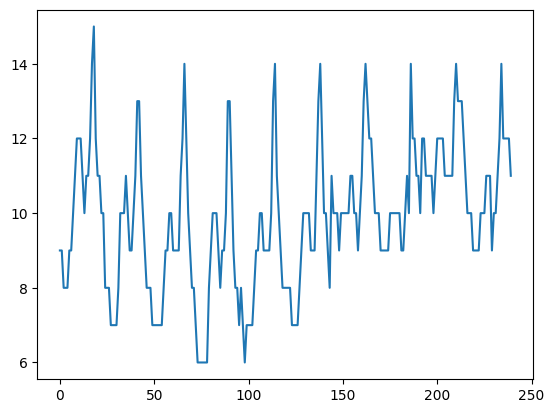

In [9]:
import matplotlib.pyplot as plot
# restaring the index
infoToUseFiltered.index = np.arange(1, len(infoToUseFiltered) + 1, 1)
print(infoToUseFiltered)
# reshape the data
dataToFit = []
for k in range(1, 11):
    print(k)
    data = infoToUseFiltered.loc[k,['dem1', 'dem2', 'dem3', 'dem4', 'dem5', 'dem6', 'dem7', 'dem8', 'dem9', 'dem10', 'dem11', 'dem12', 'dem13', 'dem14', 'dem15', 'dem16', 'dem17', 'dem18', 'dem19', 'dem20', 'dem21', 'dem22', 'dem23', 'dem24']]
    data = np.array(data)    
    dataToFit.append(data)
dataToFit = np.array(dataToFit)
dataToFit = dataToFit.flatten()
dataToFit = np.float64(dataToFit)
plot.plot(dataToFit)
np.sum(dataToFit)
np.mean(dataToFit)

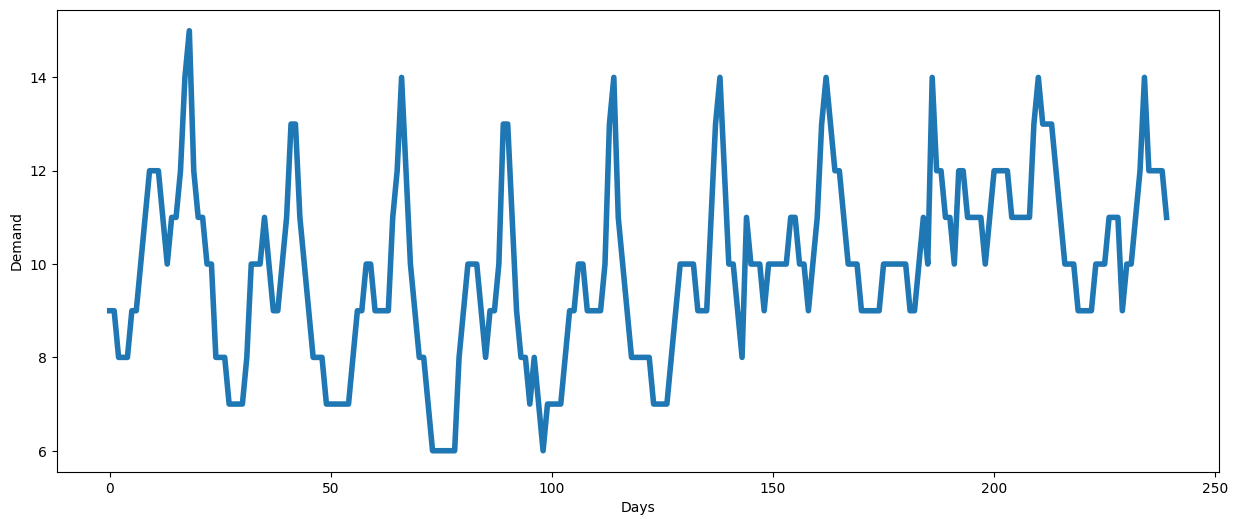

In [10]:
plt.figure(figsize = (15,6))
plt.plot(dataToFit,linewidth = 4)
plt.xlabel('Days')
plt.ylabel('Demand')
plt.show()

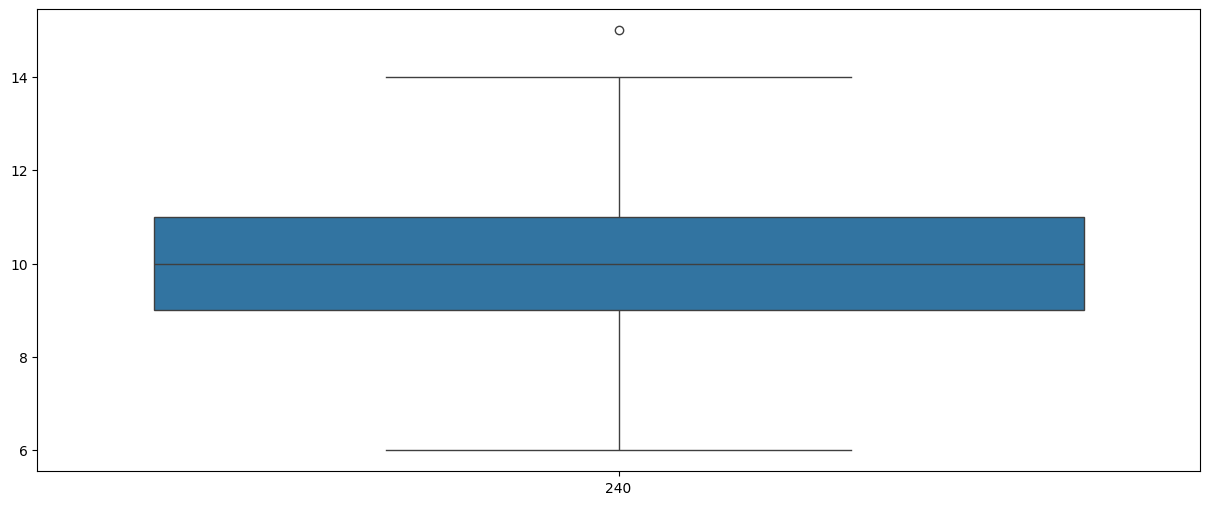

In [11]:
plt.figure(figsize = (15,6))
sns.boxplot(x = len(dataToFit), y = dataToFit)
plt.show()

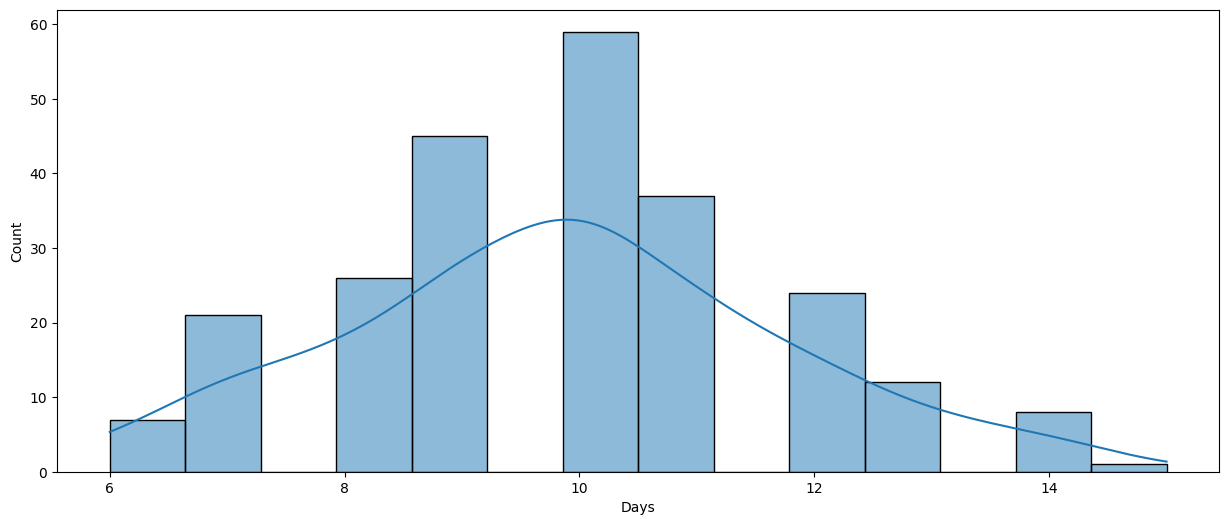

In [12]:
 #? Density Plot
plt.figure(figsize = (15,6))
sns.histplot(dataToFit, kde = True)
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()

<Figure size 1800x800 with 0 Axes>

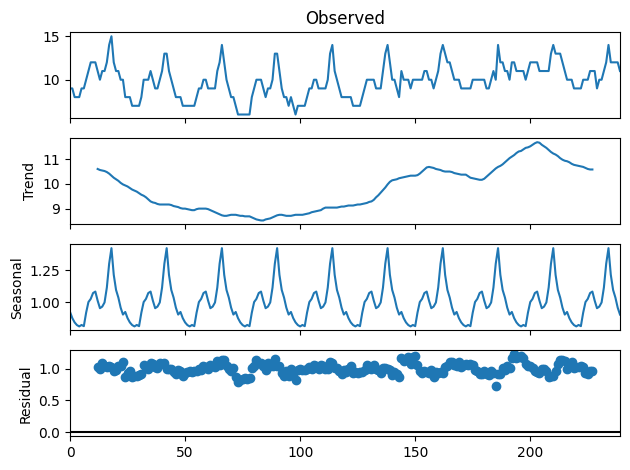

In [13]:
 #? Decomposition  of a array 
decomposition = sm.tsa.seasonal_decompose(dataToFit, model='multiplicative',period=24)
#? Plot data 
plt.figure(figsize=(18,8))
decomposition.plot()
plt.show()

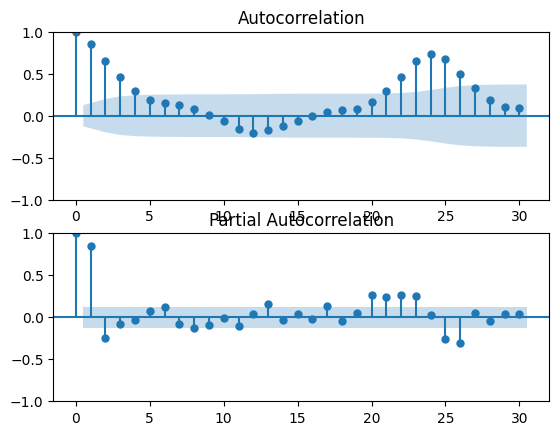

In [14]:
# ACF & PACF Plots
plt.figure()
plt.subplot(211)
plot_acf(dataToFit, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(dataToFit, ax=plt.gca(), lags = 30)
plt.show()

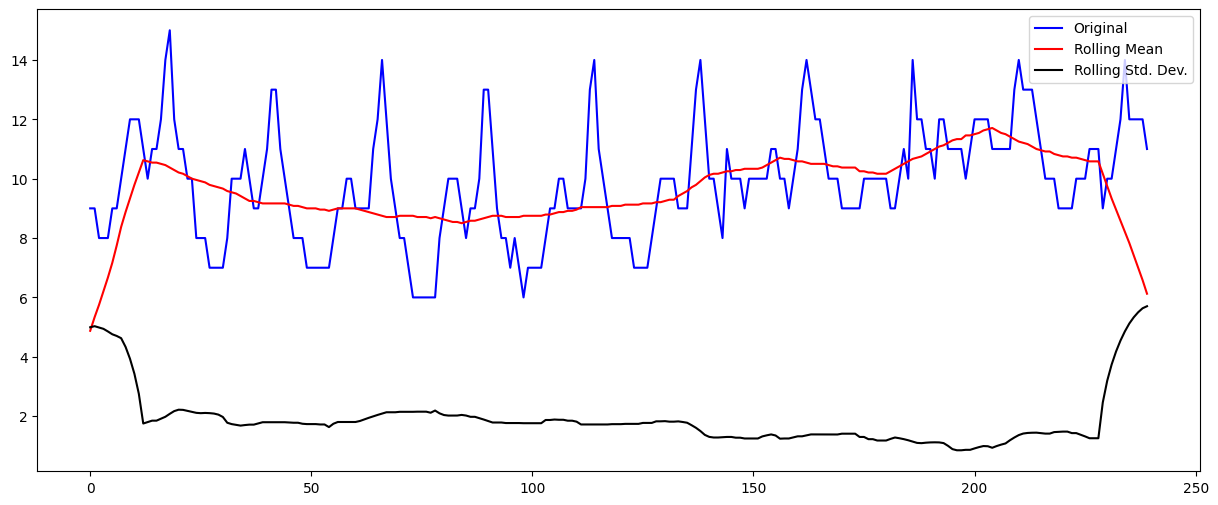

In [15]:

#? Convert the array to a NumPy array
dataToFit_np = np.array(dataToFit)

#? Calculate the rolling mean and standard deviation with a window of 24 hours
rolmean = np.convolve(dataToFit_np, np.ones(24)/24, mode='same')
rolstd = np.sqrt(np.convolve(dataToFit_np**2, np.ones(24)/24, mode='same') - rolmean**2)

# Plot the original data, rolling mean, and rolling standard deviation
plt.figure(figsize=(15,6))
orig = plt.plot(dataToFit_np, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std. Dev.')
plt.legend(loc='best')
plt.show()

In [16]:
def test_stationarity(Array,p):

    # Rolling Mean & Rolling Standard Deviation
    rolmean = np.convolve(dataToFit_np, np.ones(24)/24, mode='same')
    rolstd = np.sqrt(np.convolve(dataToFit_np**2, np.ones(p)/p, mode='same') - rolmean**2)

    plt.figure(figsize = (15,6))
    orig = plt.plot(Array, color = 'blue', label ='Original')
    mean  = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std. Dev.')
    plt.legend(loc = 'best')
    plt.show()

    # # Augmented Dicky-Fuller Test
    print('-------------Results of Dicky Fuller Test -------------')
    dftest = adfuller(Array, autolag = 'AIC')
    dfoutput = pd.Series(data = dftest[0:4], index = ['Test Statistic : adf', 'p-value : MacKinnon\'s approximate p-value',
                                                'No. of Lags used', 'No. of observations used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    dfoutput['Maximized AIC:'] = dftest[5]
    print(dfoutput)
    if dftest[1]>0.05 :
            print("the null hypothesis is fulfilled for no stationary series ")
    else:
        print("the  hypothesis is fulfilled for  stationary series ")

    # #! Agree the Levene test
    # Divide the data into three equal parts
    
    if len(Array)//2==0 :
        part_size = len(Array) // 2
        seg1 = Array[:part_size]
        seg2 = Array[2*part_size:]
            # # Apply the levene test to each pair of segments
        resultado_levene_seg1_seg2 = levene(seg1, seg2)
    # Apply the levene test to each pair of segments
         # # Print the results
        print("Valor p de la prueba de levene para seg1 y seg2:", resultado_levene_seg1_seg2.pvalue)
        if resultado_levene_seg1_seg2.pvalue < 0.05:
            print('La serie no es estacionaria en VARIANZA')
        else:
            print('La serie es estacionaria en VARIANZA')
    else:
    # Adjust the parts size if needed to make them approximately equal
        part_size = len(Array) // 3
        # Divide the series into three parts
        seg1 = Array[:part_size]
        seg2 = Array[part_size:2*part_size]
        seg3 = Array[2*part_size:]
        print(seg3)
        # Apply the levene test to each pair of segments
        resultado_levene_seg1_seg2 = levene(seg1, seg2)
        resultado_levene_seg2_seg3 = levene(seg2, seg3)
        resultado_levene_seg3_seg1 = levene(seg3, seg1)

        # Print the results
        print("Valor p de la prueba de levene para seg1 y seg2:", resultado_levene_seg1_seg2.pvalue)
        print("Valor p de la prueba de levene para seg2 y seg3:", resultado_levene_seg2_seg3.pvalue)
        print("Valor p de la prueba de levene para seg3 y seg1:", resultado_levene_seg3_seg1.pvalue)

        if resultado_levene_seg1_seg2.pvalue < 0.05 and resultado_levene_seg2_seg3.pvalue < 0.05 and resultado_levene_seg3_seg1.pvalue < 0.05:
            print('La serie no es estacionaria en VARIANZA')
        else:
            print('La serie es estacionaria en VARIANZA')

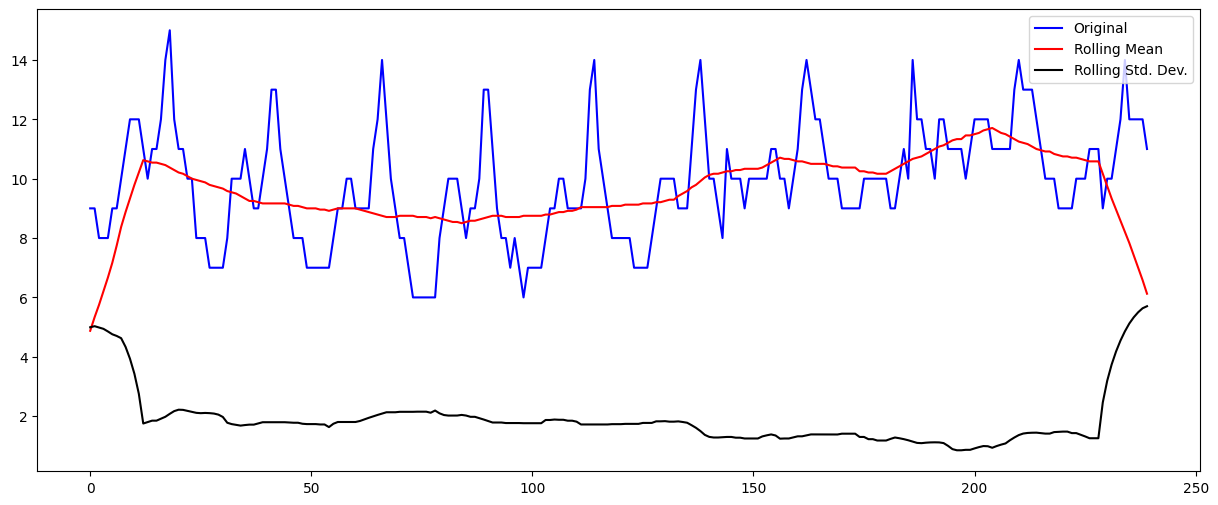

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                          -3.409709
p-value : MacKinnon's approximate p-value      0.010632
No. of Lags used                              12.000000
No. of observations used                     227.000000
Critical Value (1%)                           -3.459490
Critical Value (5%)                           -2.874358
Critical Value (10%)                          -2.573602
Maximized AIC:                               627.859209
dtype: float64
the  hypothesis is fulfilled for  stationary series 
[11. 13. 14. 13. 12. 12. 11. 10. 10. 10.  9.  9.  9.  9.  9. 10. 10. 10.
 10. 10. 10.  9.  9. 10. 11. 10. 14. 12. 12. 11. 11. 10. 12. 12. 11. 11.
 11. 11. 10. 11. 12. 12. 12. 12. 11. 11. 11. 11. 11. 13. 14. 13. 13. 13.
 12. 11. 10. 10. 10.  9.  9.  9.  9. 10. 10. 10. 11. 11. 11.  9. 10. 10.
 11. 12. 14. 12. 12. 12. 12. 11.]
Valor p de la prueba de levene para seg1 y seg2: 0.04558203103211679
Valor p de la prueba de levene pa

In [17]:
test_stationarity(dataToFit,24)

In [18]:
 #? Divide array in half
half = len(dataToFit) // 2
train_ts = dataToFit[:half]
test_ts = dataToFit[half:]

In [19]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
model = auto_arima(
            y                 = dataToFit,
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 24, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True,
            random_state      =42,
            n_fits            =15000
)
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=758.343, Time=1.86 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=985.825, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=588.610, Time=2.05 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=751.405, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1790.759, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=681.637, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=541.536, Time=1.77 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=640.693, Time=0.26 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=527.723, Time=3.37 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=527.281, Time=4.16 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=6.62 sec
 ARIMA(0,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=4.52 sec
 ARIMA(2,0,0)(2,0,2)[24] intercept   : AIC=519.932, Time=7.16 sec
 ARIMA(2,0,0)(1,0,2)[24] intercept   : AIC=i

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def modelSARIMAX(dataToFit):
     # creating the object model SARIMAX(02,0,0) x (2,0,1)24
    model = SARIMAX(dataToFit,order=(2,0,0),seasonal_order=(2,0,1,24))
    model_fit = model.fit() # fit model
    return model_fit

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  240
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 24)   Log Likelihood                -262.125
Date:                              Sun, 19 May 2024   AIC                            536.250
Time:                                      15:22:59   BIC                            557.134
Sample:                                           0   HQIC                           544.664
                                              - 240                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7040      0.056     12.525      0.000       0.594       0.814
ar.L2          0.26

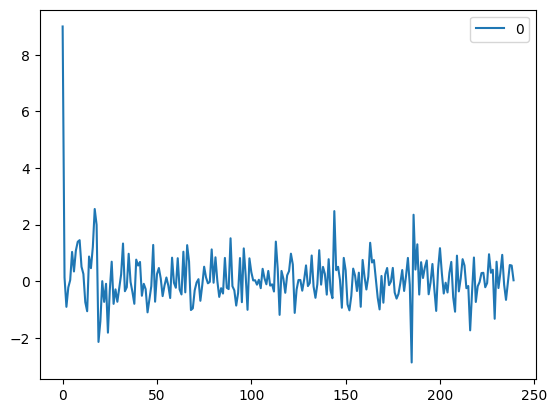

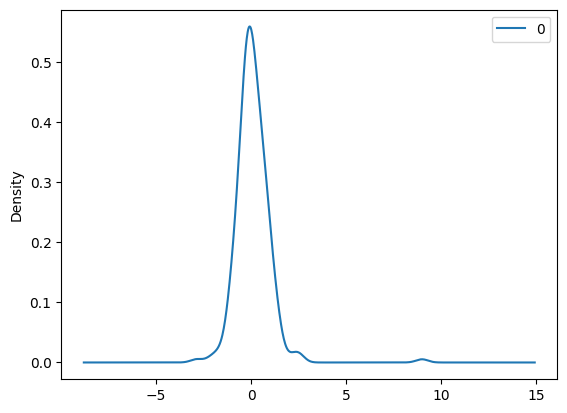

                0
count  240.000000
mean     0.097676
std      0.933909
min     -2.873562
25%     -0.357079
50%      0.001260
75%      0.507511
max      9.000000


In [21]:
model_fitted = modelSARIMAX(dataToFit)
# summary of fit model
print(model_fitted.summary()) 
# line plot of residuals
residuals = pd.DataFrame(model_fitted.resid) 
residuals.plot()
print("Residuals Plot")
plot.show()
# density plot of residuals
residuals.plot(kind='kde') 
plot.show() 
# summary stats of residuals
print(residuals.describe()) 



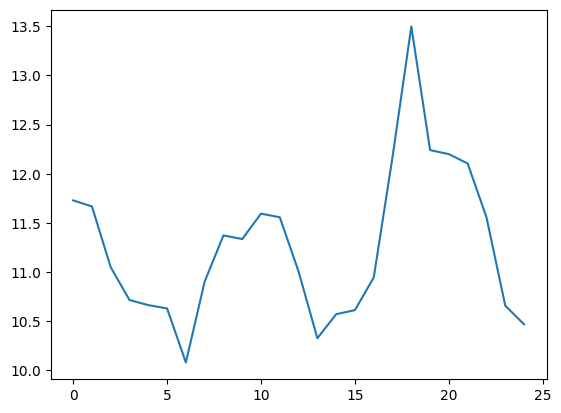

In [22]:
# predictions
yhat = model_fitted.predict(start=len(dataToFit), end=len(dataToFit) + 24)
plot.plot(yhat)

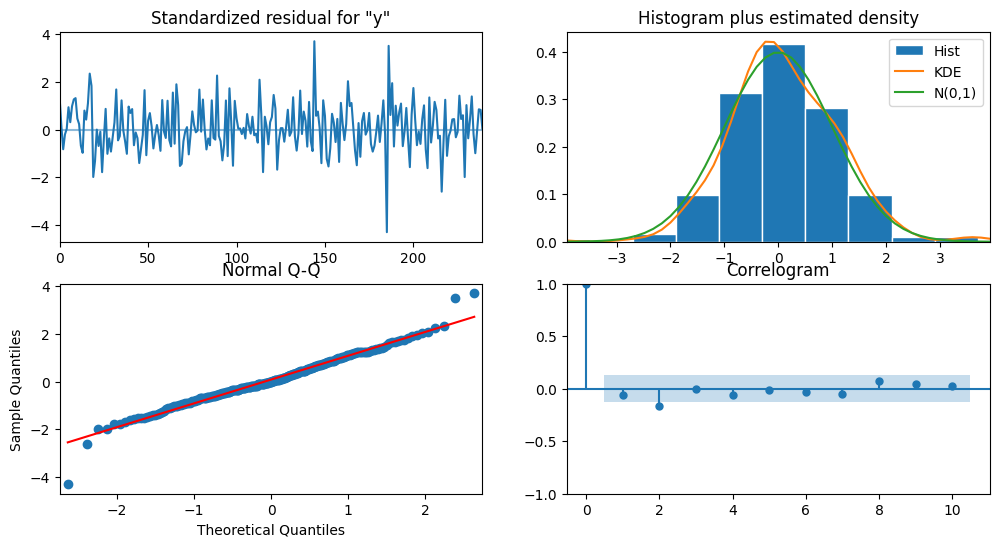

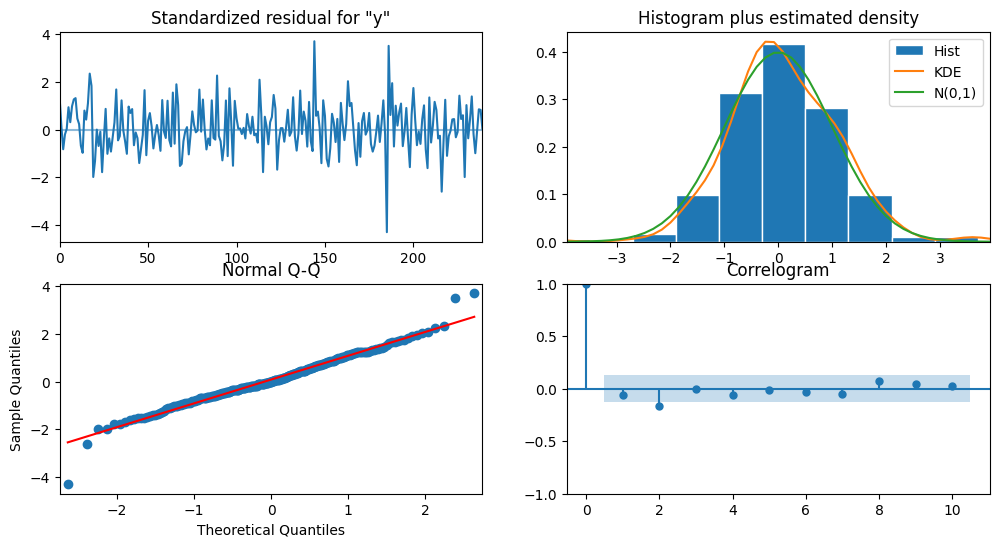

In [23]:
# diagnostics
model_fitted.plot_diagnostics(figsize=(12, 6))

In [24]:
 #? Prediction 
origin = pd.DataFrame(dataToFit, columns=['Origin'])

predictions = model.predict(n_periods=120)
predictions_test_=model.predict(len(test_ts))
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])
predictions_df.index = predictions_df. index +240
print(predictions_df)
predictions_df.describe()

     Predictions
240    11.889496
241    11.664537
242    11.119761
243    10.815309
244    10.642195
..           ...
355    11.905771
356    11.845456
357    11.827889
358    11.428800
359    10.782426

[120 rows x 1 columns]


,Predictions
count,120.000000
mean,11.016316
std,0.842870
min,9.460446
25%,10.463920
50%,10.884457
75%,11.589701
max,13.711397


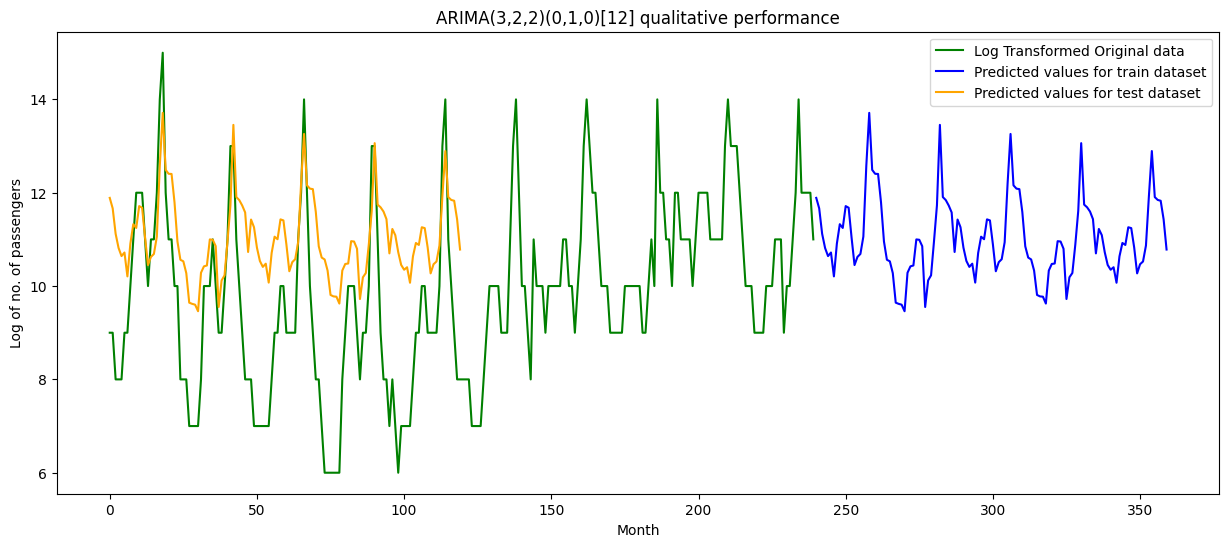

In [25]:
plt.figure(figsize = (15,6))
plt.plot(origin, color = 'green', label = 'Log Transformed Original data')
plt.plot(predictions_df, color = 'blue', label = 'Predicted values for train dataset')
plt.plot(predictions, color = 'orange', label = 'Predicted values for test dataset')
plt.xlabel('Month')
plt.ylabel('Log of no. of passengers')
plt.title('ARIMA(3,2,2)(0,1,0)[12] qualitative performance')
plt.legend(loc = 'best')
plt.show()


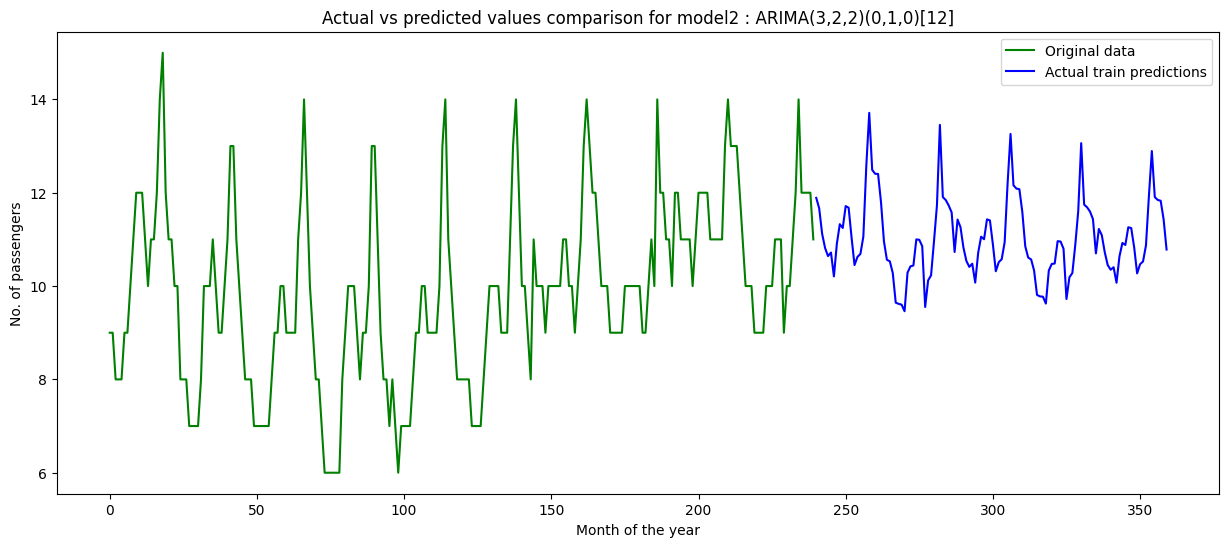

In [26]:

# Plotting actual vs forecasted values
plt.figure(figsize = (15,6))
plt.plot(origin, color = 'green', label = 'Original data')
plt.plot(predictions_df, color = 'blue', label = 'Actual train predictions')
plt.ylabel('No. of passengers')
plt.xlabel('Month of the year')
plt.title('Actual vs predicted values comparison for model2 : ARIMA(3,2,2)(0,1,0)[12]')
plt.legend(loc = 'best')
plt.show()

In [27]:
o = origin.iloc[120:240,]
model = ARIMA(o, order = (2,0,0), seasonal_order=(2,0,1,24))
results = model.fit()

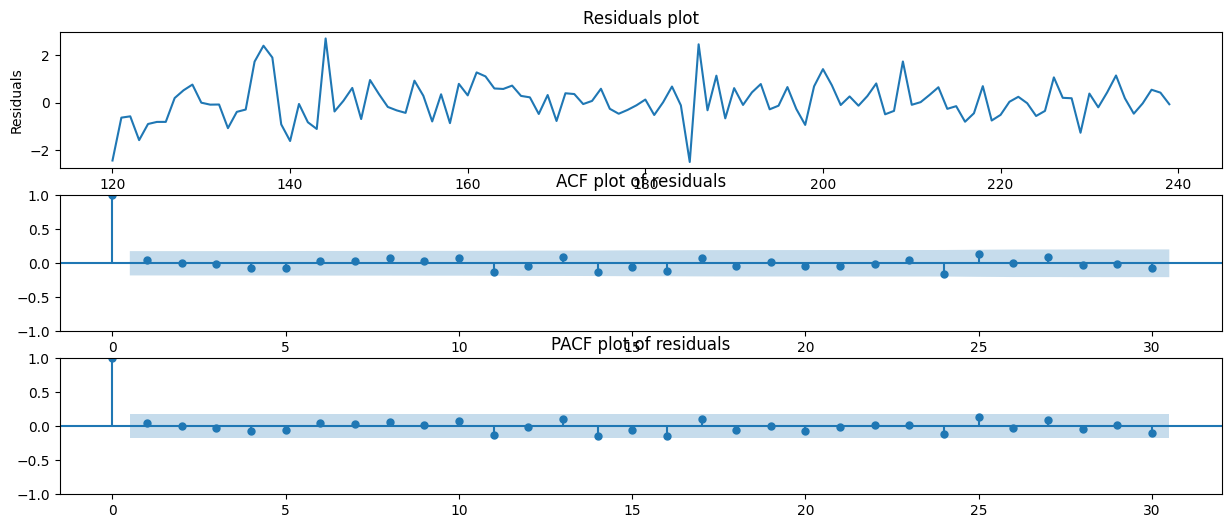

In [28]:
# Validating our best model chosen => model2 => ARIMA(3,2,2)(0,1,0)
residual = results.resid

# 1. Checking white noise of residuals
plt.figure(figsize = (15,6))
plt.subplot(3,1,1)
residual.plot(kind = 'line', xlabel = 'Month', ylabel = 'Residuals', title = 'Residuals plot')
plt.subplot(3,1,2)
plot_acf(residual, ax=plt.gca(), lags = 30, title = 'ACF plot of residuals')
plt.subplot(3,1,3)
plot_pacf(residual, ax=plt.gca(), lags = 30, title = 'PACF plot of residuals')
plt.show()

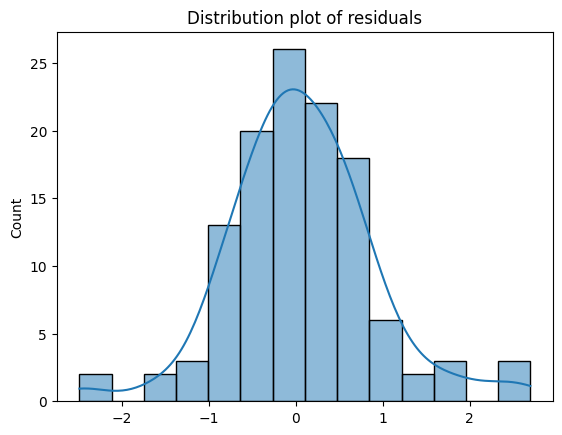

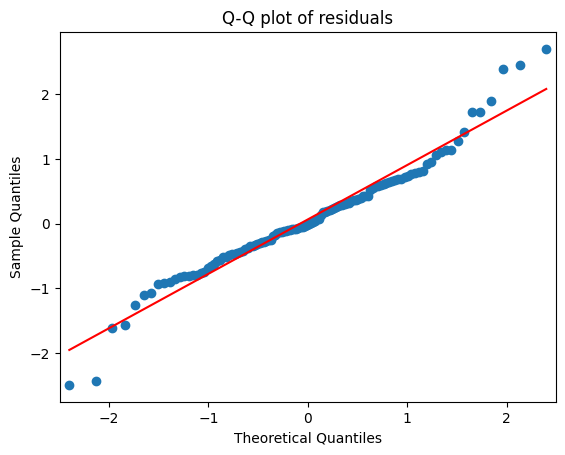

In [29]:
# 2. Checking normality of residuals using distribution plot and q-q plot
plt.figure()
sns.histplot(residual, kde = True)
plt.title('Distribution plot of residuals')
sm.qqplot(residual, line = 'r')
plt.title('Q-Q plot of residuals')
plt.show()
